In [241]:
import numpy as np
import pandas as pd
import os

# initialize datasets
gender_submission = None
test = None
train = None

# find file paths for and read in datasets
for subdir, dirs, files in os.walk("titanic\data"):
    for file in files:
        # print(os.path.join(subdir, file))

        if 'gender_submission' in file:
            gender_submission = pd.read_csv(os.path.join(subdir, file))

        if 'test' in file:
            test = pd.read_csv(os.path.join(subdir, file))

        if 'train' in file:
            train = pd.read_csv(os.path.join(subdir, file))

In [242]:
# analyze and clean data
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms = ms[ms["Percent"] > 0]
    f,ax = plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig = seaborn.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

# missingdata(train)
# missingdata(test)


# now fill in missing values for both train and test data
# test['Age'].fillna(test['Age'].mean(), inplace=True)
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)


# from the graphs shown for the missing data, cabin features has more than 75% of missing data in both train and test data => remove the feature from both datasets
train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Fare'].fillna(test['Fare'].median(), inplace=True)


# print('check the nan value in train data')
# print(train.isnull().sum())
# print('___'*30)
# print('check the nan value in test data')
# print(test.isnull().sum())

In [243]:
# feature engineering
import re
all_data = [train, test]

# both train and test datasets contain Parch (parents/children), SibSp (siblings/spouses)), and the person related to => this must be the entire family size
for dataset in all_data:
    dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp'] + 1


# extract titles from passenger names
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)

    # if title exists, extract and return
    if title_search:
        return title_search.group(1)
    return ""


# create a new feature 'Title', containing titles of passenger names
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)


# group all non-common titles into one single grouping "Rare"
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


# create bin for age features
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0, 12, 20, 40, 120], labels=['Children', 'Teenager', 'Adult', 'Elder'])


# create bin for fare features
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0, 7.91, 14.45, 31, 120], labels=['Low_fare', 'Median_fare', 'Average_fare', 'High_fare'])


# drop unnecessary columns
for dataset in all_data:
    drop_column = ['Age', 'Fare', 'Name', 'Ticket']
    dataset.drop(drop_column, axis=1, inplace=True)

train.drop(['PassengerId'], axis=1, inplace=True)

In [265]:
# visualization after cleaning and aggregating features
import seaborn
import matplotlib.pyplot as plt

# X = pd.get_dummies(train, prefix=["Sex","Title","Age_type","Em_type","Fare_type"], columns=["Sex","Title","Age_bin","Embarked","Fare_bin"])
# X_test = pd.get_dummies(test, prefix=["Sex","Title","Age_type","Em_type","Fare_type"], columns=["Sex","Title","Age_bin","Embarked","Fare_bin"])


# # heatmap of data correlation => confusion matrix
# seaborn.heatmap(X.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
# fig = plt.gcf()
# fig.set_size_inches(20, 12)
# plt.show()
#
#
# # pair plots
# g = seaborn.pairplot(data=X, hue='Survived', palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
# g.set(xticklabels = [])


In [267]:
# find rate (%) of women who survived the Titanic
women = train.loc[train.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)

print(f"% of women who survived: {rate_women}")


# find rate (%) of men who survived the Titanic
men = train.loc[train.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)

print(f"% of men who survived: {rate_men}")

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


In [253]:
# random forests
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

# TESTING WITH NO FEATURE ENGINEERING
# Y = train['Survived']
# features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']  # submit with 'Fare' as feature
# X = pd.get_dummies(train[features])
# X_test = pd.get_dummies(test[features])


# TESTING WITH FEATURE ENGINEERING
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'FamilySize', 'Title', 'Age_bin', 'Fare_bin']
X = pd.get_dummies(train[features])
Y = train["Survived"]
X_test = pd.get_dummies(test[features])


# MAKING PREDICTIONS
predictions = []
for k in range(1, 26):
    model = RandomForestClassifier(n_estimators=20, max_depth=k, random_state=None)
    model.fit(X, Y)
    print(f"{k} = {model.score(X, Y)}")

    predictions.append(model.predict(X_test))

# print(model.get_params())

1 = 0.7867564534231201
2 = 0.8013468013468014
3 = 0.8305274971941639
4 = 0.835016835016835
5 = 0.8361391694725028
6 = 0.8518518518518519
7 = 0.8597081930415263
8 = 0.8630751964085297
9 = 0.8742985409652076
10 = 0.8754208754208754
11 = 0.8765432098765432
12 = 0.8765432098765432
13 = 0.8765432098765432
14 = 0.8754208754208754
15 = 0.8765432098765432
16 = 0.8765432098765432
17 = 0.8765432098765432
18 = 0.8731762065095399
19 = 0.8765432098765432
20 = 0.8754208754208754
21 = 0.8742985409652076
22 = 0.8765432098765432
23 = 0.8765432098765432
24 = 0.8765432098765432
25 = 0.8754208754208754


In [226]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions[3]})
output.to_csv('submission_RandomForests.csv', index=False)
print('output successful')

# output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions[3]})  # keep this prediction
# output.to_csv('submission_RandomForestsFeatureEngineering.csv', index=False)
# print('output successful')

output successful


In [160]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

Y = train['Survived']
features = ['Pclass', 'Sex', 'SibSp', 'Parch']

X_train = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

logisticRegressionModel = LogisticRegression()
logisticRegressionModel.fit(X_train, Y)
print(logisticRegressionModel.score(X_train, Y))

predictions = logisticRegressionModel.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission_LogisticRegression.csv', index=False)
print('output successful')

0.8002244668911336
output successful


In [ ]:
# decision tree regression
from sklearn.tree import DecisionTreeRegressor

Y = train['Survived']
features = ['Pclass', 'Sex', 'SibSp', 'Parch']

X_train = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

decisionTreeRegressorModel = DecisionTreeRegressor(random_state=1)
decisionTreeRegressorModel.fit(X_train, Y);

print(decisionTreeRegressorModel.score(X_train, Y))

predictions = np.array(decisionTreeRegressorModel.predict(X_test))
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission_DecisionTreeRegression.csv', index=False)
print('output successful')

In [ ]:
# svm
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score


Y = train['Survived']
features = ['Pclass', 'Sex', 'SibSp', 'Parch']

X_train = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

svmModel = svm.SVC(kernel='linear', C=1, random_state=0)
svmModel.fit(X_train, Y);

print(svmModel.score(X_train, Y))
predictions = svmModel.predict(X_test);

scores = cross_val_score(svmModel, X_train, Y, cv=5, scoring="f1_weighted")
print(f"max score: {max(scores)}")
print(f"min score: {min(scores)}")
print(f"mean score: {scores.mean()}")
print(f"std score: {scores.std()}")


def custom_cv_2folds(X):
    n = X.shape[0]
    i = 1
    while i <= 2:
        idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
        yield idx, idx
        i += 1

custom_cv = custom_cv_2folds(X_train)
custom_score = cross_val_score(svmModel, X_train, Y, cv=custom_cv)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission_SVM.csv', index=False)
print('output successful')

Logistic Regression Accuracy Score: 0.9904306220095693
Random Forests Accuracy Score: 0.9880382775119617
SVM Accuracy Score: 1.0
Decision Tree Regression Accuracy Score: 0.9449760765550239



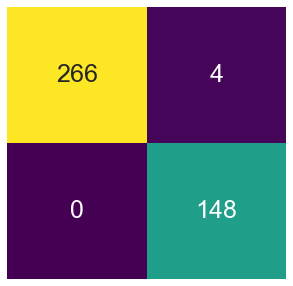

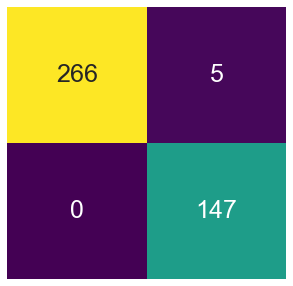

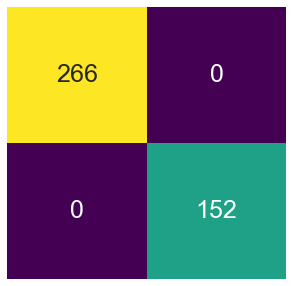

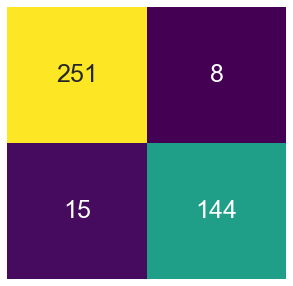

In [90]:
# confusion matrix
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


logisticRegressionSubmission = pd.read_csv('submission_LogisticRegression.csv')
randomForestsSubmission = pd.read_csv('submission_RandomForests.csv')
SVMSubmission = pd.read_csv('submission_SVM.csv')
decisionTreeRegressionSubmission = pd.read_csv('submission_DecisionTreeRegression.csv')

print(f"Logistic Regression Accuracy Score: {accuracy_score(logisticRegressionSubmission['Survived'], gender_submission['Survived'])}")
print(f"Random Forests Accuracy Score: {accuracy_score(randomForestsSubmission['Survived'], gender_submission['Survived'])}")
print(f"SVM Accuracy Score: {accuracy_score(SVMSubmission['Survived'], gender_submission['Survived'])}")
print(f"Decision Tree Regression Accuracy Score: {accuracy_score(decisionTreeRegressionSubmission['Survived'], gender_submission['Survived'])}\n")


Y = train['Survived']
features = ['Pclass', 'Sex', 'SibSp', 'Parch']

X_train = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])


# create heatmaps for all submissions
# [TN, FP]
# [FN, TP]

for submission in [logisticRegressionSubmission, randomForestsSubmission, SVMSubmission, decisionTreeRegressionSubmission]:
    cm = confusion_matrix(submission['Survived'], gender_submission['Survived']);  # get confusion matrix for y_true vs y_pred
    cm_df = pd.DataFrame(cm);

    plt.figure(figsize=(5, 5));
    seaborn.heatmap(cm_df, annot=True, annot_kws={"size": 25}, fmt='d', xticklabels=False, yticklabels=False, cmap="viridis", cbar=False);
    plt.show();

In [12]:
# logistic regression with feature engineering
import pandas as pd
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix


traindf = pd.get_dummies(train, prefix=["Sex","Title","Age_type","Em_type","Fare_type"], columns=["Sex","Title","Age_bin","Embarked","Fare_bin"])
testdf = pd.get_dummies(test, prefix=["Sex","Title","Age_type","Em_type","Fare_type"], columns=["Sex","Title","Age_bin","Embarked","Fare_bin"])


all_features = traindf.drop("Survived",axis=1)
Targeted_feature = traindf["Survived"]
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 22), (268, 22), (623,), (268,))

In [230]:
train_X = traindf.drop("Survived", axis=1)
train_Y=traindf["Survived"]
test_X  = testdf.drop("PassengerId", axis=1).copy()
train_X.shape, train_Y.shape, test_X.shape

((891, 22), (891,), (418, 22))

In [238]:
# random forests with feature engineering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#                                             max_depth=3, max_features='auto', max_leaf_nodes=None,
#                                             min_impurity_decrease=0.0,
#                                             min_samples_leaf=1, min_samples_split=2,
#                                             min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
#                                             oob_score=False, random_state=None, verbose=0,
#                                             warm_start=False)
# random_forest.fit(train_X, train_Y)
# # predictions = random_forest.predict(test_X)
# random_forest.score(train_X,train_Y)
#
# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10, 12], "n_estimators": [50, 100, 400, 700]}
#
# gs = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
#
# gs = gs.fit(train_X, train_Y)
#
# predictions = gs.predict(test_X)
#
# print(gs.score(train_X, train_Y))
#
#
# output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
# output.to_csv('temp.csv', index=False)
# print('output successful')


predictions = []
for k in range(0, 20):
    random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                                            max_depth=(k+1), max_features='sqrt', max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_samples_leaf=1, min_samples_split=2,
                                            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
                                            oob_score=False, random_state=None, verbose=0,
                                            warm_start=False)
    random_forest.fit(train_X, train_Y)
    predictions.append(random_forest.predict(test_X))
    random_forest.score(train_X,train_Y)

    print(f"{k} = {random_forest.score(train_X, train_Y)}")

0 = 0.7845117845117845
1 = 0.7867564534231201
2 = 0.8114478114478114
3 = 0.835016835016835
4 = 0.8361391694725028
5 = 0.8552188552188552
6 = 0.8585858585858586
7 = 0.8664421997755332
8 = 0.8832772166105499
9 = 0.8888888888888888
10 = 0.8866442199775533
11 = 0.8900112233445566
12 = 0.8900112233445566
13 = 0.8900112233445566
14 = 0.8911335578002245
15 = 0.8888888888888888
16 = 0.8888888888888888
17 = 0.8911335578002245
18 = 0.8911335578002245
19 = 0.8911335578002245


In [240]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions[3]})
output.to_csv('temp.csv', index=False)
print('output successful')

output successful
